# Project 1
## MC886 A - Machine Learning
### Profª Esther Colombini
#### First Semester 2021

# Group

- Mariana Megumi Izumizawa - RA 221859
- Matheus Carvalho Hatzlhoffer- RA 222174

# Clusterization Problem

Given unlabeled data points, the objective is to group some of the data into a cluster that are similar inside each group. This way we need to find patterns in the data and build a solution that creates new clusters using unsupervised machine learning algorithm.

## Group contribution

We worked in a pair programming format so it was a very collaborative project. But if we had to assign each one with a part, we would divide: Matheus worked more in the k-means model and ran PCA over our data and Mariana helped more in DBSCAN construction and in the report description.

# Part I - Clustering Methods

Implementation of k-means and another unsupervised learning method, in our case it is DBSCAN (Density Based Spatial Clustering of Application with Noise).

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math
from sklearn.decomposition import PCA
import warnings

## Data splitting in training and test sets
Returns first `training set` and then `test set` depending on the percentage in argument.

In [ ]:
def split_data(data, test_percent):
  test_numbers = int(round(test_percent*len(data)))
  shuffled_data = np.array(data)
  np.random.shuffle(shuffled_data)
  return shuffled_data[test_numbers:], shuffled_data[:test_numbers]

## Distance calculation
Euclidian distance as 

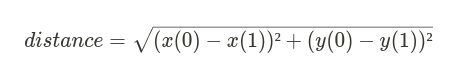

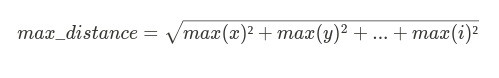

In [ ]:
def euclidian_distance(a, b):
  dist = 0
  for i in range(len(a)):
    dist = dist + math.pow(a[i] - b[i], 2) + math.pow(a[i] - b[i], 2)
  return math.sqrt(dist)

In [ ]:
def max_distance(data):
  dist = 0
  for i in range(len(data[0])):
    dist += math.pow(np.max(data, axis=0)[i], 2)
  return math.sqrt(dist)

## Pre-processing data

Data normalization using the following formula:

![Formula](https://miro.medium.com/max/341/0*oRhJXkyKqqYp8--e.)

In [ ]:
def normalization(data):
  max_x = np.max(data, axis=0)[0]
  min_x = np.min(data, axis=0)[0]
  max_y = np.max(data, axis=0)[1]
  min_y = np.min(data, axis=0)[1]
  for x in data:
    x[0] = (x[0] - min_x)/(max_x - min_x)
    x[1] = (x[1] - min_y)/(max_y - min_y)

## Evaluate with silhouette score 
Returns `silhouette score` but if there is an error, it returns `-2`

The intracluster distance a is the mean of the distance between the sample and every other sample in the same cluster.

The intercluster distance b is the mean of the distance between the sample and every other sample in the nearest cluster. The nearest cluster is defined by the closest point that belongs a different cluster. 

In [ ]:
def silhouette_score(data, label):
  if (max(label) < 2):
    # print("Error: there is only one cluster. Number of clusters must be greater than one.")
    return -2
  # a = mean intra cluster distance
  # b = mean nearest cluster distance
  silhouette_score_sample_list = []
  mean_intra_cluster_samples = [] # a
  sample_nearest_cluster = np.array([-1]*len(data))
  mean_nearest_cluster_samples = [] # b

  max_dist = max_distance(data)

  for i in range(len(data)):
    if (label[i] == 0):
      continue
    sample_mean_intra = []
    sample_min_dist_cluster = max_dist
    for j in range(len(data)):
      dist = euclidian_distance(data[i], data[j])
      if (label[i] == label[j]):
        sample_mean_intra.append(dist)
      else:
        if (dist <= sample_min_dist_cluster):
          sample_min_dist_cluster = dist
          sample_nearest_cluster[i] = label[j]
    mean_intra_cluster_samples.append(np.mean(np.array(sample_mean_intra)))

  for i in range(len(data)):
    if (label[i] == 0):
      continue
    sample_mean_nearest = []
    for j in range(len(data)):
      if (label[j] == sample_nearest_cluster[i]):
        dist = euclidian_distance(data[i], data[j])
        sample_mean_nearest.append(dist)
    mean_nearest_cluster_samples.append(np.mean(np.array(sample_mean_nearest)))

  if (len(mean_intra_cluster_samples) != len(mean_nearest_cluster_samples)):
    # print("Error: mean intra-cluster distance and mean nearest-cluster distance have different sizes.")
    return -2
  # s = (b-a)/ max(a,b)
  for i in range(len(mean_nearest_cluster_samples)):
    silhouette_score_sample = (mean_nearest_cluster_samples[i] - mean_intra_cluster_samples[i])/(max(mean_nearest_cluster_samples[i], mean_intra_cluster_samples[i]))
    silhouette_score_sample_list.append(silhouette_score_sample)
  silhouette_score = np.mean(np.array(silhouette_score_sample_list))
  return silhouette_score

## K-means implementation

In [ ]:
def k_means(k, data):
  centers = np.array(random.sample(list(data), k))
  old_centers = np.zeros(centers.shape)
  clusters = []
  label = []

  if (k <= 1):
    print("Error: Number of clusters must be greater than 1.")
    return -1, -1

  for i in range(k):
    clusters.append([])

  while not (np.array_equal(old_centers, centers)):
    label = []
    for i in range(k):
      clusters[i] = []
    old_centers = deepcopy(centers)
    for i in range(len(data)):
      winner_distance = max_distance(data)
      winner_cluster = 1
      for j in range(len(centers)):
        distance = euclidian_distance(centers[j], data[i])
        if (distance < winner_distance):
          winner_distance = distance
          winner_cluster = j + 1
      clusters[winner_cluster - 1].append(list(data[i].astype(float)))
      label.append(winner_cluster)

    for i in range(k):
      for j in range(len(data[0])):
        center_j = np.mean([x[j] for x in clusters[i]])
        centers[i][j] = center_j

  return centers, label

## Show clusters with different colors
It plots colorful clusters receiving `data`, `label`, `centers` and `title`.

In [ ]:
def print_clusters(data, label, *args, **kwargs):
  n_cluster = max(label)
  if (max(label) == 0):
    n_cluster = 1
  for i in range(len(data)):
    colors = cm.rainbow(np.array(label).astype(float) / n_cluster)
    plt.scatter(data[:,0], data[:,1], color=colors, s=10)

  if (args != ()):
    plt.scatter(args[0][:,0], args[0][:,1], c='black')
  plt.grid()
  plt.title(kwargs["title"])
  plt.show()

## Plot silhouette score for k-means
It plots different silhouette scores for different values of k in k-means.

In [ ]:
def print_silhouette_score_kmeans(k_min, k_max, data):
  for k in range(k_min, k_max+1):
    centers, label = k_means(k, data)
    y = silhouette_score(data, label)
    if (y != -2):
      plt.bar(k, y)
  plt.title("Silhouette score for k-means")
  plt.xlabel("clusters")
  plt.ylabel("Silhouette score")
  plt.show()

## Implementation of DBSCAN

In [ ]:
def get_neighbors(data, index, eps):
  neighbors = []
  for i in range(len(data)):
    if (euclidian_distance(data[i], data[index]) <= eps):
      neighbors.append(i)
  return neighbors

def dbscan(data, eps, min_points=4):
  cluster_id = 0
  label = [-1]*len(data)
  shuffled_index = np.arange(len(data))
  np.random.shuffle(shuffled_index)

  for i in shuffled_index:
    if (label[i] == -1):
      neighbors = get_neighbors(data, i, eps)
      if (len(neighbors) < min_points):
        label[i] = 0
      else:
        cluster_id += 1
        label[i] = cluster_id
        seed_set = deepcopy(neighbors)
        seed_set.pop(neighbors.index(i))
        for x in seed_set:
          if (label[x] == 0):
            label[x] = cluster_id
          elif (label[x] == -1):
            label[x] = cluster_id
            neighbors = get_neighbors(data, x, eps)
            if (len(neighbors) >= min_points):
              for y in neighbors:
                seed_set.append(y)
  return label

## Choosing the best DBSCAN clusterization

We tried to create a KNN distance plot so we could choose the best epsilon value. In this case, we would see the first plot knee and choose the best epsilon value. However, we weren't able to analyse the plot's knee and the `k_nearest_neighbor` value was skewed by the data quantity.

After trying KNN approach, we decided to run several different values for epsilon, analyse the best silhouette score for these values and then choose the best label.

In [ ]:
def k_nearest_neighbor(k, data):
  k_distances = []
  for i in range(len(data)):
    point_distances = []
    for j in range(len(data)):
      distance = euclidian_distance(data[i], data[j])
      point_distances.append(distance)
    point_distances.sort()
    k_distances.append(point_distances[k]) # K neighbor
  k_distances.sort(reverse = True)
  x = [y+1 for y in range(len(data))]
  plt.plot(x, k_distances)
  plt.title("k-dist")
  plt.xlabel("sorted data points")
  plt.ylabel("KNN distance")
  plt.show()

  x1, y1 = 0, k_distances[0]
  x2, y2 = len(data), k_distances[len(k_distances)-1]

  distances = []
  for i in range(len(k_distances)):
    x0 = i
    y0 = k_distances[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)
  return k_distances[distances.index(max(distances))]

In [ ]:
def best_clusters_dbscan(data, iter_n, min_points, min_eps, max_eps, step):
  best_silhouette_score = -1
  best_label = []
  eps = min_eps
  while (eps <= max_eps):
    for i in range(iter_n):
      label = dbscan(data, eps, min_points)
      current_silhouette_score = silhouette_score(data, label)
      if (current_silhouette_score > best_silhouette_score):
        best_silhouette_score = current_silhouette_score
        best_label = deepcopy(label)
    eps += step
  return best_label, best_silhouette_score

## Apply functions with given dataset (`cluster.dat`)

First we had to clean dataset to a better format to work with.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cluster.dat to cluster.dat


In [ ]:
string_data = ([np.array(x.split(" ")) for x in uploaded['cluster.dat'].decode("utf-8").split('\n')])
# Cleaning data
string_data = string_data[:-1]
data = np.array([x.astype(float) for x in string_data])

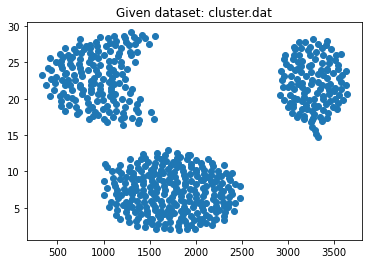

In [ ]:
plt.scatter(data[:,0], data[:,1])
plt.title("Given dataset: cluster.dat")
plt.show()

## K-means training

Before using the data.dat we normalized it because if we didn't, the x value would influence too much in the distance between the points not giving a good clusterization 

With k-means and DBSCAN implemented, we split sets and train the models with 90% of the given dataset. 

After splitting data into training and test set, we normalize dataset to get rid of anomalies and create new values maintaining the original general distribution and original ratios.

Then we train our k-means model with training set. To choose the best k value for the specific data, we analyzed silhouette score for six different `k` and chose 3 as the `k` with highest score.


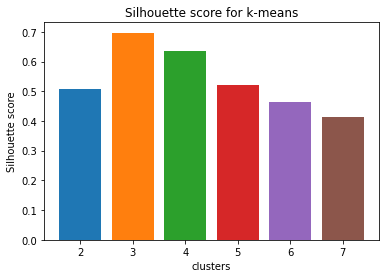

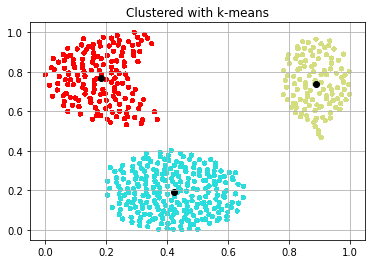

In [ ]:
training_set, test_set = split_data(data, 0.1)
normalization(training_set)
print_silhouette_score_kmeans(2, 7, training_set)
centers, label_k_means = k_means(3, training_set)
print_clusters(training_set, label_k_means, centers, title = "Clustered with k-means")

## DBSCAN training

Since we had implementation for DBSCAN and choosing the best epsilon for DBSCAN, we trained model with the training set and several epsilon values (variating from 0.1 to 0.5 with 0.05 step). Our `best_cluster_dbscan` returned labels and silhouette score for the best epsilon.
The we plotted DBSCAN clusterization and printed the silhouette score for these labels, as shown below:

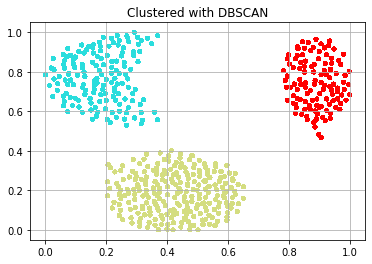

Silhouette score: 0.70


In [ ]:
label_dbscan, current_silhouette_score = best_clusters_dbscan(training_set, 5, 4, 0.1, 0.5, 0.05)
print_clusters(training_set, label_dbscan, title = "Clustered with DBSCAN")
print("Silhouette score: %.2f" % current_silhouette_score)

## The Usage of KNN

In the graph, we couldn't specify the elbow with a good precision  

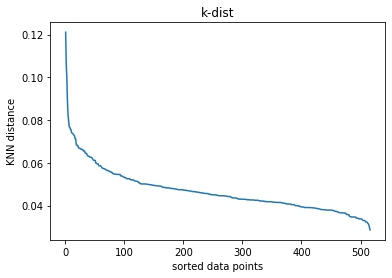

0.05735279401704383

In [ ]:
k_nearest_neighbor(4, training_set)

## Testing set

After training k-means and DBSCAN models, we needed to test with labeled data and `test_set`.

The next graph have the test points (smaller points) labeled by the nearest centers (bigger points). The results shows that the test points are near of the respectives centers as expected 

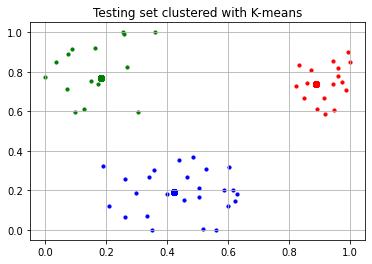

In [ ]:
def set_k_means_cluster(test_set, centers):
  label = [-1]*len(test_set)
  max_x = max(np.max(test_set, axis=0)[0], np.max(centers, axis=0)[0])
  min_x = min(np.min(test_set, axis=0)[0], np.min(centers, axis=0)[0])
  max_y = max(np.max(test_set, axis=0)[1], np.max(centers, axis=0)[1])
  min_y = min(np.min(test_set, axis=0)[1], np.min(centers, axis=0)[1])

  for i in range(len(test_set)):
    winner_distance = euclidian_distance([max_x, max_y], [min_x, min_y])
    for j in range(len(centers)):
      dist = euclidian_distance(test_set[i], centers[j])
      if (dist < winner_distance):
        winner_distance = dist
        label[i] = j + 1
  return label

normalization(test_set)
label_k_means_test = set_k_means_cluster(test_set, centers)
for i in range(len(test_set)):
  if (label_k_means_test[i] == 1):
    plt.scatter(test_set[i][0], test_set[i][1], color="blue", s=10)
    plt.scatter(centers[0][0], centers[0][1], color="blue")
  if (label_k_means_test[i] == 2):
    plt.scatter(test_set[i][0], test_set[i][1], color="red", s=10)
    plt.scatter(centers[1][0], centers[1][1], color="red")
  if (label_k_means_test[i] == 3):
    plt.scatter(test_set[i][0], test_set[i][1], color="green", s=10)
    plt.scatter(centers[2][0], centers[2][1], color="green")
plt.title("Testing set clustered with K-means")
plt.grid()
plt.show()

In DBSCAN we labeled each test point with the label of it nearest training test. And again we have a very satisfactory results.

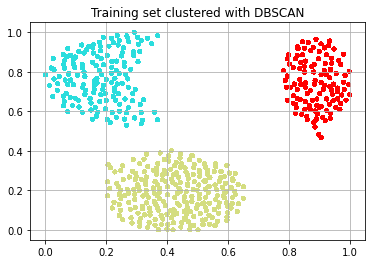

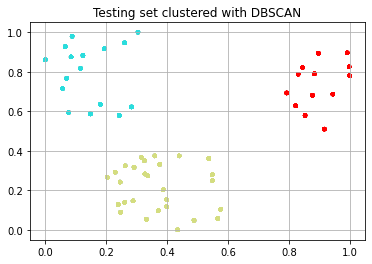

In [ ]:
def set_dbscan_cluster(test_set, training_set, label):
  label_dbscan_test = [-1]*len(test_set)
  max_x = max(np.max(test_set, axis=0)[0], np.max(training_set, axis=0)[0])
  min_x = min(np.min(test_set, axis=0)[0], np.min(training_set, axis=0)[0])
  max_y = max(np.max(test_set, axis=0)[1], np.max(training_set, axis=0)[1])
  min_y = min(np.min(test_set, axis=0)[1], np.min(training_set, axis=0)[1])

  for i in range(len(test_set)):
    winner_distance = euclidian_distance([max_x, max_y], [min_x, min_y])
    for j in range(len(training_set)):
      dist = euclidian_distance(test_set[i], training_set[j])
      if (dist < winner_distance):
        winner_distance = dist
        label_dbscan_test[i] = label[j]
  return label_dbscan_test


label_dbscan_test = set_dbscan_cluster(test_set, training_set, label_dbscan)
print_clusters(training_set, label_dbscan, title = "Training set clustered with DBSCAN")
print_clusters(test_set, label_dbscan_test, title="Testing set clustered with DBSCAN")

# Part II - Dimensionality reduction

We used a dataset from [kaggle](https://www.kaggle.com/kashnitsky/mlcourse?select=affairs.csv) that have information about affairs outside the marriage so we can categorize people by  the affairs they had.

In [ ]:
uploaded = files.upload()

Saving affairs.csv to affairs.csv


In [ ]:
affairs_data_string = uploaded['affairs.csv'].decode("utf-8").split('\n')
affairs_data_string.pop(0)
affairs_data_string.pop(-1)
affairs_string = np.array([x.split(',') for x in affairs_data_string])
affairs_string = affairs_string[:,1:]
affairs_data = np.array([np.array(x).astype(float) for x in affairs_string])

In [ ]:
training_affair_set, test_affair_set = split_data(affairs_data, 0.5)

### Clusterization with k-means

We clustered the data without the PCA algorithms to know if the PCA would effect the clusterization  

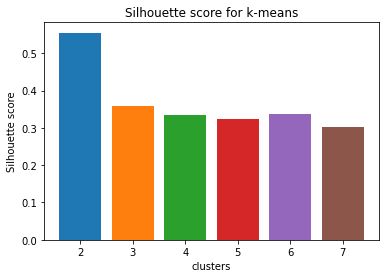

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter('error')
  print_silhouette_score_kmeans(2, 7, training_affair_set)

We have done a dimensionality reduction to fit the data in 2, 4 and 6 dimensions and in every one of than dividing the data in two cluster was the best clusterization.

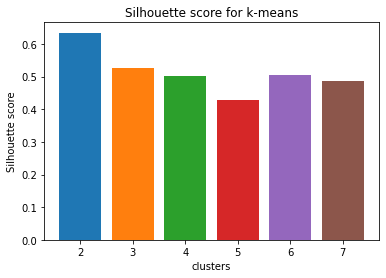

In [ ]:
pca_2_components = PCA(n_components=2)
pca_2_components.fit(training_affair_set)
affairs_2_components = pca_2_components.transform(training_affair_set)
print_silhouette_score_kmeans(2, 7, affairs_2_components)

[[12.16904953 -0.30676749]
 [-6.21447427  0.15665962]]


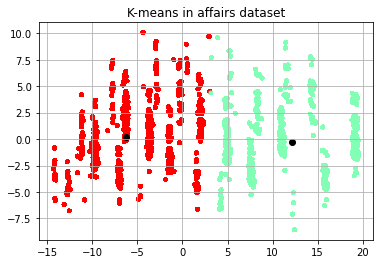

In [ ]:
centers_affairs, label_affairs = k_means(2, affairs_2_components)
print(centers_affairs)
print_clusters(affairs_2_components, label_affairs, centers_affairs, title = "K-means in affairs dataset")

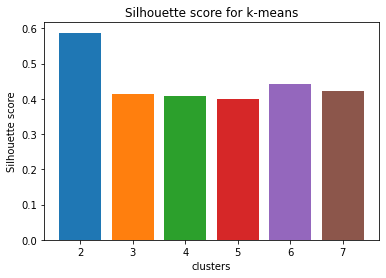

In [ ]:
pca_4_components = PCA(n_components=4)
pca_4_components.fit(training_affair_set)
affairs_4_components = pca_4_components.transform(training_affair_set)
with warnings.catch_warnings():
  warnings.simplefilter('error')
  print_silhouette_score_kmeans(2, 7, affairs_4_components)

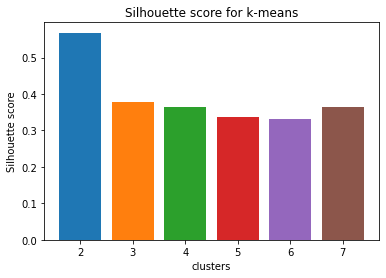

In [ ]:
pca_6_components = PCA(n_components=6)
pca_6_components.fit(training_affair_set)
affairs_6_components = pca_6_components.transform(training_affair_set)
print_silhouette_score_kmeans(2, 7, affairs_6_components)

###Clusterization with DBSCAN

The result was not as expected. The silhouette score was lower than the expected and lower than the 2-means' silhouette score.

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter('error')
  normalization(affairs_2_components)
  label_dbscan_affair, current_silhouette_score_affair = best_clusters_dbscan(affairs_2_components, 5, 4, 0.1, 0.5, 0.05)

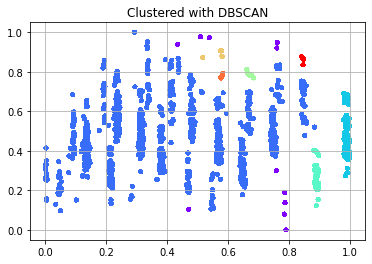

In [ ]:
print_clusters(affairs_2_components, label_dbscan_affair, title = "Clustered with DBSCAN")

In [ ]:
print("Silhouette score: %.2f" %current_silhouette_score_affair)

Silhouette score: 0.36


#Discussion

As a result we can observe that our data wasn't a great fit for k-means algorithm. 

Although k-means is a fast method (it doesn't need many computations) and it is good in capturing structure of the data if clusters have a spherical-like shape, and the `affairs_data` doesn't have a circular shape. So it tries to build and spherical shape around the centers as we can see in the `k_means` output.

To sum up, k-means is not very good in data that has complex geometric shape and it lacks of consistence depending a lot on how the centers are initialized and on feature scalling.

Another conclusion we have is that the best k-means clusterization maintained along 3 different energies, from the silhouette coeficient graphs we see that 2 clusters are the best value for our `affairs_data.` Therefore we can conclude that normalizing the dataset is very essencial because it can decrease running time and still maintains a great clusterization. 

Also, we implemented DBSCAN in part one of this project. This algorithm does not need a pre-set number of clusters unlike k-means, and it can identify outliers as noise. When we ran DBSCAN with `cluster.dat` dataset, it didn't output any outliers but when we ran it with `affairs_data` we can see some points that would be classified as noise (purple dots). 

However DBSCAN is not very effective if clusters vary densities, as we can see plotting the last graph. Besides that this model is very sensitive about its parameters, specially on how the distance epsilon and minimum point for each neighborhood are set. It is a difficult task choosing the best distance for neighbors and the minimum points for a complex and large dataset.